# **Predicting Electricity Spot Prices Based on Weather Patterns in Nordic Countries**

In this project, I will combine weather, electricity spot price and energy productionn and consumption data for Norway in the perido of 2017-2019.

https://www.statnett.no/en/
https://www.ncdc.noaa.gov/cdo-web/
https://www.energidataservice.dk/tso-electricity/Elspotprices

In [1]:
#Set up and Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px

print("Libaries imported")

Libaries imported


In [2]:
#Loading Data
weather_df = pd.read_csv('/kaggle/input/finland-norway-and-sweden-weather-data-20152019/nordics_weather.csv')
electricity_df = pd.read_csv('/kaggle/input/electricity-spot-price/Elspotprices.csv', delimiter=';')

# List of production and consumption CSV files.
production_consumption_files = ['/kaggle/input/production-and-consumption2017-2019/ProductionConsumption-2017.csv', 
                                '/kaggle/input/production-and-consumption2017-2019/ProductionConsumption-2018.csv', 
                                '/kaggle/input/production-and-consumption2017-2019/ProductionConsumption-2019.csv']

# Read production and comsumption CSV files into dataframes and concatenate them together.
dfs = [pd.read_csv(file, delimiter=';') for file in production_consumption_files]
production_consumption_df = pd.concat(dfs, ignore_index=True)

print("Datasets Loaded")

Datasets Loaded


In [3]:
# Basic exploration
print(weather_df.head())
print(weather_df.dtypes)
print(weather_df.isnull().sum())

print(electricity_df.head())
print(electricity_df.dtypes)
print(electricity_df.isnull().sum())

print(production_consumption_df.head())
print(production_consumption_df .dtypes)
print(production_consumption_df .isnull().sum())

   country      date  precipitation  snow_depth       tavg      tmax  \
0  Finland  1/1/2015       1.714141  284.545455   1.428571  2.912739   
1  Finland  1/2/2015      10.016667  195.000000   0.553571  2.358599   
2  Finland  1/3/2015       3.956061  284.294118  -1.739286  0.820382   
3  Finland  1/4/2015       0.246193  260.772727  -7.035714 -3.110828   
4  Finland  1/5/2015       0.036364  236.900000 -17.164286 -8.727564   

        tmin  
0  -1.015287  
1  -0.998718  
2  -3.463871  
3  -9.502581  
4 -19.004487  
country           object
date              object
precipitation    float64
snow_depth       float64
tavg             float64
tmax             float64
tmin             float64
dtype: object
country          0
date             0
precipitation    0
snow_depth       0
tavg             0
tmax             0
tmin             0
dtype: int64
            HourUTC            HourDK PriceArea SpotPriceDKK SpotPriceEUR
0  2022-10-19 21:00  2022-10-19 23:00       DK2   978,750000   131,5

Based on the inital exploration of the datasets, we can see there are no missing values but the data structure needs to be cleaned and parsed correctly and the time zones need to be aligned.

Weather Data:
There are no missing values and the data appears to be clean.

The 'date' column is currently type 'object', which needs to be converted to 'datetime' and set as the index. This will allow for easier time series analysis and aslignment with the other datasets.

Electricity Spot Price Data:
Therer are no missing values but the dataset requires some cleaning.

The dataframe formatting means we need to load the data with a delimiter ';'

I will remove the 'SpotPriceDKK', 'HourDK' and 'PriceArea' columns due to redudency.

The 'SpotPriceEUR' column has commas not dots in the decimal place, this will cause issues when convering them to numerical values. These converted to 'float'.

The 'HourUTC'column is a strings, which need to be converted to 'datetime' for time-based analysis just like our other datasets. I will set 'HourUTC' as the index.

Production and Conmsumption Data: ---
The dataframe formatting means we need to load the data with a delimiter ';'
I also need to specify the correct formating for the date and time before converting to datetime and setting it the index.


In [4]:
#Clean Weather Dataset

# Covert 'date' to 'datetime' and set 'date' as index
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.set_index('date', inplace=True)

print(weather_df.head())
print(weather_df.dtypes)

            country  precipitation  snow_depth       tavg      tmax       tmin
date                                                                          
2015-01-01  Finland       1.714141  284.545455   1.428571  2.912739  -1.015287
2015-01-02  Finland      10.016667  195.000000   0.553571  2.358599  -0.998718
2015-01-03  Finland       3.956061  284.294118  -1.739286  0.820382  -3.463871
2015-01-04  Finland       0.246193  260.772727  -7.035714 -3.110828  -9.502581
2015-01-05  Finland       0.036364  236.900000 -17.164286 -8.727564 -19.004487
country           object
precipitation    float64
snow_depth       float64
tavg             float64
tmax             float64
tmin             float64
dtype: object


In [5]:
#Clean Electricity Spot Price Dataset

# Convert the spot prices to numeric, handling commas and converting to float values.
electricity_df['SpotPriceEUR'] = electricity_df['SpotPriceEUR'].str.replace(',', '').astype(float)

# Convert the 'HourUTC' column to datetime
electricity_df['HourUTC'] = pd.to_datetime(electricity_df['HourUTC'])

# Set 'HourUTC' as index for the electricity data
electricity_df.set_index('HourUTC', inplace=True)

# Drop the redundant columns 'SpotPriceDKK' and 'TimeDKK'
electricity_df = electricity_df.drop(columns=['SpotPriceDKK', 'HourDK', 'PriceArea'])


print(electricity_df.head())
print(electricity_df.dtypes)

                     SpotPriceEUR
HourUTC                          
2022-10-19 21:00:00   131570007.0
2022-10-19 20:00:00   148149994.0
2022-10-19 19:00:00   146570007.0
2022-10-19 18:00:00   166500000.0
2022-10-19 17:00:00   226919998.0
SpotPriceEUR    float64
dtype: object


In [6]:
# Clean Production and Consumption Dataset

# Convert 'Time' to datetime without timezone information
production_consumption_df['Time'] = pd.to_datetime(production_consumption_df['Time'])

# 3. Set 'Time' as index
production_consumption_df.set_index('Time', inplace=True)

# Display the first few rows and the data types
print(production_consumption_df.head())
print(production_consumption_df.dtypes)


                     Production  Consumption
Time                                        
2017-01-01 00:00:00       12316        14912
2017-01-01 01:00:00       12189        14786
2017-01-01 02:00:00       11992        14638
2017-01-01 03:00:00       11646        14442
2017-01-01 04:00:00       11760        14392
Production     int64
Consumption    int64
dtype: object


There is an overlaping time frame from 2017 to 2019 which will be where I merge the datasets for futher analysis and filter the weather dataset for Norway specificly.

In [7]:
# Filter the datasets to match the time range of (2017-2019)
weather_df_filtered = weather_df[
    (weather_df.index >= '2017-01-01') & (weather_df.index <= '2019-12-31') & (weather_df['country'] == 'Norway')
]
electricity_df_filtered = electricity_df[
    (electricity_df.index >= '2017-01-01') & (electricity_df.index <= '2019-12-31')
]
production_consumption_df_filtered = production_consumption_df[
    (production_consumption_df.index >= '2017-01-01') & (production_consumption_df.index <= '2019-12-31')
]

# Merge electricity and weather data
merged_df_1 = pd.merge(
    electricity_df_filtered, 
    weather_df_filtered, 
    left_on='HourUTC', 
    right_index=True, 
    how='inner'
)

# Merge the result with production_consumption_df
merged_df = pd.merge(
    merged_df_1, 
    production_consumption_df_filtered, 
    left_on='HourUTC', 
    right_index=True, 
    how='inner'
)

# Remove duplicates (if any)
merged_df = merged_df.drop_duplicates()

# Reset the index for easier manipulation
merged_df.reset_index(inplace=True)

# Display the first few rows of the merged dataframe
print(merged_df.head())
print(merged_df.dtypes)

     HourUTC  SpotPriceEUR country  precipitation  snow_depth      tavg  \
0 2019-12-31    21590000.0  Norway       4.920921  161.163158 -0.666667   
1 2019-12-30    11840000.0  Norway       7.822269  163.234375  1.757895   
2 2019-12-29    28100000.0  Norway      19.756303  195.814815  2.657895   
3 2019-12-28    32320000.0  Norway       9.156303  204.497355 -1.105263   
4 2019-12-27    32930000.0  Norway       1.078992  202.026042 -4.578947   

       tmax      tmin  Production  Consumption  
0  3.388462 -1.637500       11446        15347  
1  6.254455  1.238614       11231        15318  
2  6.792308  0.575000       13266        16359  
3  2.185000 -5.410680       14896        17849  
4 -1.467308 -7.728155       13386        17300  
HourUTC          datetime64[ns]
SpotPriceEUR            float64
country                  object
precipitation           float64
snow_depth              float64
tavg                    float64
tmax                    float64
tmin                    float64

#Outliers

Due to the nature of spot price and to some exten production and cinsumption it would be benefitial to look for outliers that could skew the data iun futher analysis.


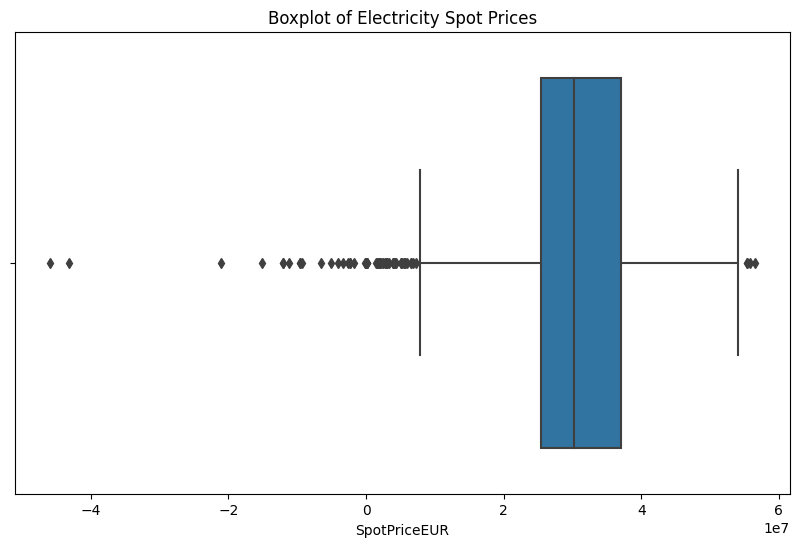

        HourUTC  SpotPriceEUR country  precipitation  snow_depth      tavg  \
16   2019-12-15     1520000.0  Norway       3.417647  190.433155  0.252632   
20   2019-12-11     2400000.0  Norway       4.750420  183.941489 -0.515789   
22   2019-12-09   -15100000.0  Norway       2.627311  182.204188 -4.242105   
24   2019-12-07     4160000.0  Norway       8.477311  138.629630 -1.984211   
80   2019-10-12    -2660000.0  Norway       3.358577    3.016760  3.415789   
...         ...           ...     ...            ...         ...       ...   
1040 2017-02-24           0.0  Norway       1.913919  225.442478 -4.642105   
1041 2017-02-23    -5030000.0  Norway       1.905861  208.116592 -4.463158   
1044 2017-02-20     1900000.0  Norway       8.589011  162.393805 -1.663158   
1083 2017-01-12     2760000.0  Norway       4.138686  186.602679 -2.068421   
1091 2017-01-04      -50000.0  Norway       0.465201  190.672646 -7.336842   

          tmax      tmin  Production  Consumption  
16    2.662

In [8]:
#Boxplot of Spotprice to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['SpotPriceEUR'])
plt.title("Boxplot of Electricity Spot Prices")
plt.show()

#Using IQR to verify the results from the inital Boxpot
Q1 = merged_df['SpotPriceEUR'].quantile(0.25)
Q3 = merged_df['SpotPriceEUR'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = merged_df[(merged_df['SpotPriceEUR'] < lower_bound) | (merged_df['SpotPriceEUR'] > upper_bound)]
print(outliers)

Based on the initial results from the boxplot and IQR. There are some outliers / anomalies that need more investigation. Initially I want to check the negative values in the spot price against the production and consumption values to see if these values are realistic of over production / under consumption or if they are indeed an outliers / anomalies.

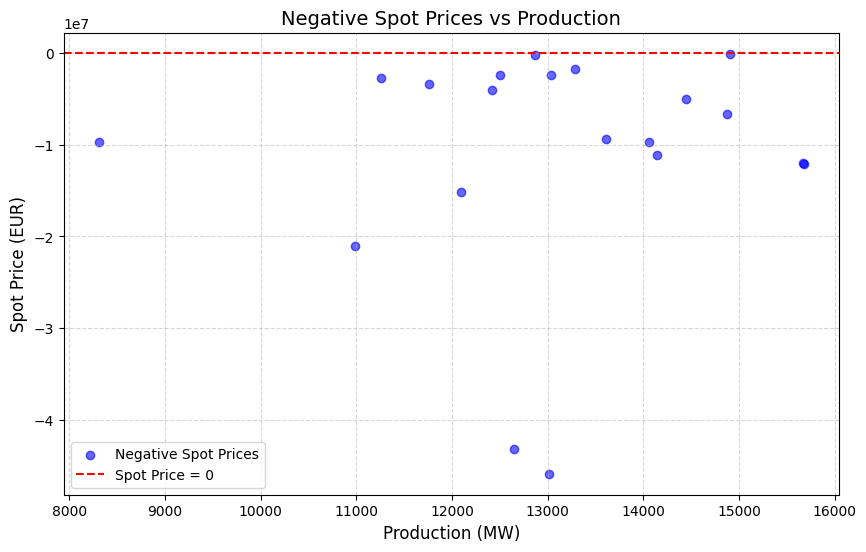

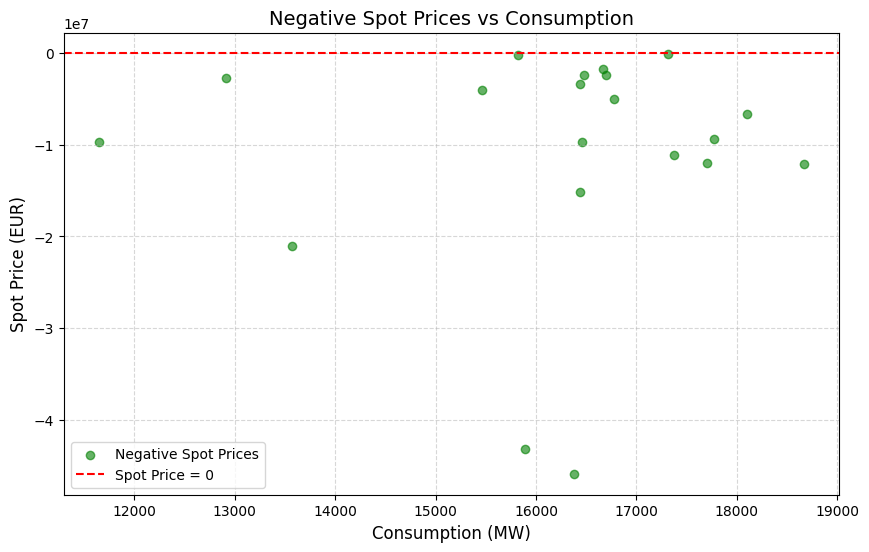

In [9]:
# Filter for negative spot prices
negative_prices = merged_df[merged_df['SpotPriceEUR'] < 0]

# Plot Spot Price vs Production
plt.figure(figsize=(10, 6))
plt.scatter(negative_prices['Production'], negative_prices['SpotPriceEUR'], color='blue', alpha=0.6, label="Negative Spot Prices")
plt.xlabel('Production (MW)', fontsize=12)
plt.ylabel('Spot Price (EUR)', fontsize=12)
plt.title('Negative Spot Prices vs Production', fontsize=14)
plt.axhline(0, color='red', linestyle='--', label='Spot Price = 0')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot Spot Price vs Consumption
plt.figure(figsize=(10, 6))
plt.scatter(negative_prices['Consumption'], negative_prices['SpotPriceEUR'], color='green', alpha=0.6, label="Negative Spot Prices")
plt.xlabel('Consumption (MW)', fontsize=12)
plt.ylabel('Spot Price (EUR)', fontsize=12)
plt.title('Negative Spot Prices vs Consumption', fontsize=14)
plt.axhline(0, color='red', linestyle='--', label='Spot Price = 0')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
